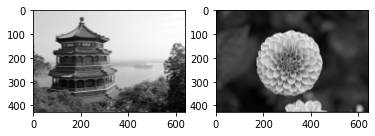

In [1]:
#CNN in Tensorflow
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images and scale to 0 to 1
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2),
    dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

# Convolve with padding ("SAME")
# Images is a mini-batch (4D tensor)
# Filters is what to apply (also 4D tensor)
outputs = tf.nn.conv2d(images, filters, strides=1,
    padding="SAME")

plt.subplot(121)
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.subplot(122)
plt.imshow(outputs[1, :, :, 0], cmap="gray") # plot 2nd image's 1st feature map
plt.show()


#Create a trainable convolutional layer
conv = keras.layers.Conv2D(filters=32, kernel_size=3,
    strides=1, padding="same", activation="relu")

In [12]:
#Max Pooling
max_pool = keras.layers.MaxPool2D(pool_size=2)
avg_pool = keras.layers.AvgPool2D(pool_size=2)

#Depthwise Max Pooling Layer
output = tf.nn.max_pool(images,
    ksize=(1, 1, 1, 3),
    strides=(1, 1, 1, 3),
    padding="VALID")
#Wrap in a layer with Keras
depth_pool = keras.layers.Lambda( lambda X: tf.nn.max_pool(X, 
    ksize=(1, 1, 1,3), strides=(1, 1, 1, 3), padding="VALID"))

#Global Average Pool
global_avg_pool = keras.layers.GlobalAvgPool2D()
#OR
# global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1,2]))

In [13]:
#Fashion MNIST CNN
fashion_mnist = keras.datasets.fashion_mnist
#Images come in as 28x28 integer arrays
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

#Split it up
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
print(X_train.shape)

#Categories
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
        input_shape=[28, 28, 0]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

In [11]:
#ResNet-34 with Keras

#Define RU Unit
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

#Rest of model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
    padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))


In [2]:
#Pretrained models from Keras
model = keras.applications.resnet50.ResNet50\
    (weights="imagenet")

#Gotta do some preprocessing
images_resized = tf.image.resize(images, [224, 224])
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
 n02825657 - bell_cote    82.35%
 n03877845 - palace       6.75%
 n03781244 - monastery    4.19%

Image #1
 n03530642 - honeycomb    49.81%
 n13040303 - stinkhorn    33.96%
 n02206856 - bee          4.35%



In [8]:
#Pretrained for Transfer Learning (Xception)
import tensorflow_datasets as tfds

#Load data
[test_set, valid_set, train_set], info = tfds.load("tf_flowers", split=[ 'train[0%:10%]', 'train[10%:25%]', 'train[25%:100%]'], 
    as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5

#Get some test and validation sets
# test_split, valid_split, train_split = tfds.Split('train').subsplit([10, 15, 75])

# test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
# valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
# train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)

#Xception preprocessing
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)


In [9]:
#Load Xception
base_model = keras.applications.xception.Xception(weights="imagenet",
    include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

#Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

#Letter rip
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

83689472/83683744 [==============================] - 13s 0us/step
Epoch 1/5
86/86 [==============================] - 277s 3s/step - loss: 1.5613 - accuracy: 0.7050 - val_loss: 1.3570 - val_accuracy: 0.8240
Epoch 2/5
86/86 [==============================] - 268s 3s/step - loss: 0.5711 - accuracy: 0.8943 - val_loss: 0.6226 - val_accuracy: 0.8893
Epoch 3/5
86/86 [==============================] - 270s 3s/step - loss: 0.1825 - accuracy: 0.9542 - val_loss: 0.6173 - val_accuracy: 0.8784
Epoch 4/5
86/86 [==============================] - 259s 3s/step - loss: 0.0920 - accuracy: 0.9674 - val_loss: 0.6913 - val_accuracy: 0.8784
Epoch 5/5
86/86 [==============================] - 278s 3s/step - loss: 0.0802 - accuracy: 0.9744 - val_loss: 0.6603 - val_accuracy: 0.8711


In [10]:
#Classification and Localization
base_model = keras.applications.xception.Xception(weights="imagenet",
    include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input,
    outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
    loss_weights=[0.8, 0.2], # depends on what you care most about
    optimizer=optimizer, metrics=["accuracy"])
